# Pendulum Harder Case

Now the following basis functions will be used:

$$
\theta, \dot{\theta}, \theta^2, \dot{\theta}^2, \theta^3, \dot{\theta}^3, \theta \cdot \dot{\theta}, \theta^2 \cdot \dot{\theta}, \theta \cdot \dot{\theta}^2 
$$

This will be harder since there are more coefficients and one of the true basis functions ($sin(\theta)$) is not present

In [ ]:
---
execute:
    echo: true
code-fold: true
output: html
toc: true
fig-align: center
fontsize: 16px
format:
    html:
        embed-resources: true
---

In [1]:
#| output: false
using Turing, DifferentialEquations, StatsPlots, LinearAlgebra, Random

## Generate Data

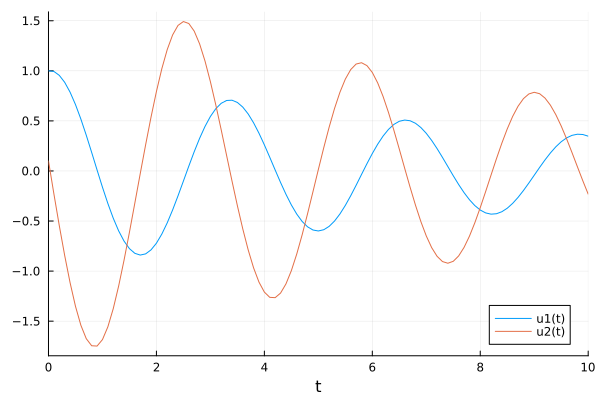

In [2]:
#| output: false

function pendulum(du,u,p,t)
    ω,L = p
    x,y = u
    du[1] = y
    du[2] = - ω*y -(9.8/L)*sin(x)
end


u0 = [1.0,0.1]
tspan = (0.0,10.0)
prob1 = ODEProblem(pendulum,u0,tspan,[0.2,2.5])

# Solve
# prob = ODEProblem(pendulum!, u0, tspan, p)
sol = solve(prob1, Tsit5(); saveat=0.1)

X = Array(sol)
t = sol.t
DX = Array(sol(sol.t,Val{1}))[[2], :]

plot(sol)

### Generate dummy data for estimation

In [1]:
t = collect(range(0.1, stop=10, length=40))

odedata = Array(solve(prob1, saveat=t))
odedata = odedata + 0.2 * randn(size(odedata))
plot(sol; alpha=0.5)
scatter!(t, odedata'; color=[1 2], label="")


UndefVarError: UndefVarError: solve not defined

## Parameter Estimation

In [4]:
#| output: false
function pendulumSindy2!(du, u, p, t)
    # u = [theta, theta_d]

    # theta_d
    du[1] = u[2]

    # theta_dd
    du[2] = (p[1]*u[1] +
             p[2]*u[2] + 
             p[3]*u[1]^2 +
             p[4]*u[2]^2 + 
             p[5]*u[1]^3 +
             p[6]*u[2]^3 + 
             p[7]*u[1]*u[2] +
             p[8]*u[1]^2*u[2] +
             p[9]*u[1]*u[2]^2)
end

sindyProb2 = ODEProblem(pendulumSindy2!, u0, tspan, [0.0 for _ in 1:9])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 0.1

In [21]:
#| output: false
@model function fitPendLaplace(data, ::Type{T} = Float64) where {T <: Real}
    # Prior distributions
    priors = [Laplace(0.0, 1.0) for _ in 1:9]
    # priors = [Normal(0.0, 1.0) for _ in 1:2]
    # priors = [truncated(Normal(0.1,1.0), lower = 0.0), truncated(Normal(3.0,1.0), lower = 0.0)]
    theta = Vector{T}(undef, length(priors))
    syms = [Turing.@varname(theta[i]) for i in 1:length(priors)]
    for i in 1:length(priors)
        theta[i] ~ NamedDist(priors[i], syms[i])
    end

    σ ~ InverseGamma(2, 3)

    p = convert.(T, theta)
    u0 = convert.(T, sindyProb2.u0)
    
    # Simulate model
    predicted = solve(sindyProb2, Tsit5(); p=p, saveat=t)#, saveat=0.1)
    predicted_dense = solve(sindyProb2, Tsit5(); p=p)#, saveat=0.1)
    failure = size(predicted, 2) < length(t)

    if failure
        Turing.@addlogprob! -Inf
        return

    end
    # Observations
    # for i in 1:length(t)
    #     data[:, i] ~ MvNormal(predicted[:, i], σ^2 * I)
    # end

    # return nothing
    return (; theta, predicted_dense)
end


fitPendLaplace (generic function with 3 methods)

In [14]:
#| output: false
modelHorse = fitPendLaplace(odedata)

chain4 = sample(modelHorse, NUTS(0.65; init_ϵ=0.01), MCMCSerial(), 500, 2; progress=true)


Sampling (Chain 1 of 2)   0%|█                          |  ETA: N/A


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)   0%|█                          |  ETA: 0:48:34


10123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)   1%|█                          |  ETA: 0:58:05


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)   1%|█                          |  ETA: 0:38:53


678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.2245167357692703. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.2245167357692703. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider usi

1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)   2%|█                          |  ETA: 0:39:28
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.8570865404442983. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\

5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)   2%|█                          |  ETA: 0:32:16


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)   2%|█                          |  ETA: 0:32:32


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)   3%|█                          |  ETA: 0:28:06


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)   3%|█                          |  ETA: 0:24:47


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)   4%|█                          |  ETA: 0:22:13


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)   4%|██                         |  ETA: 0:20:12


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)   4%|██                         |  ETA: 0:18:51


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)   5%|██                         |  ETA: 0:17:47


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)   5%|██                         |  ETA: 0:16:49


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)   6%|██                         |  ETA: 0:15:58


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)   6%|██                         |  ETA: 0:15:48


678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)   6%|██                         |  ETA: 0:14:48


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)   7%|██                         |  ETA: 0:13:59


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)   7%|██                         |  ETA: 0:13:19


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)   8%|███                        |  ETA: 0:12:43


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)   8%|███                        |  ETA: 0:12:09


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)   8%|███                        |  ETA: 0:11:34


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, tr

1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)   9%|███                        |  ETA: 0:12:33


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)   9%|███                        |  ETA: 0:12:03


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  10%|███                        |  ETA: 0:12:29


789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  10%|███                        |  ETA: 0:13:20


10123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, tr

1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  10%|███                        |  ETA: 0:15:21


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  11%|███                        |  ETA: 0:15:14


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, tr

2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  12%|████                       |  ETA: 0:16:32


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  12%|████                       |  ETA: 0:17:03


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  12%|████                       |  ETA: 0:16:38


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  13%|████                       |  ETA: 0:16:11


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  13%|████                       |  ETA: 0:15:44

1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  14%|████                       |  ETA: 0:15:17


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  14%|████                       |  ETA: 0:14:49


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  14%|████                       |  ETA: 0:15:09


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  15%|████                       |  ETA: 0:14:41


456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  15%|█████                      |  ETA: 0:14:16


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  16%|█████                      |  ETA: 0:13:54


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  16%|█████                      |  ETA: 0:14:33


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  16%|█████                      |  ETA: 0:14:13


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  17%|█████                      |  ETA: 0:13:51


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  17%|█████                      |  ETA: 0:13:31


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  18%|█████                      |  ETA: 0:13:13


910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  18%|█████                      |  ETA: 0:12:54


234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  18%|█████                      |  ETA: 0:12:35


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  19%|██████                     |  ETA: 0:12:17


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  19%|██████                     |  ETA: 0:12:00


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  20%|██████                     |  ETA: 0:11:46


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  20%|██████                     |  ETA: 0:11:37


10123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.868378186364627. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.868378186364627. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  20%|██████                     |  ETA: 0:11:21


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  21%|██████                     |  ETA: 0:11:06


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  21%|██████                     |  ETA: 0:10:50


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  22%|██████                     |  ETA: 0:10:40


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  22%|██████                     |  ETA: 0:10:27


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  22%|███████                    |  ETA: 0:10:14


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  23%|███████                    |  ETA: 0:10:02


101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  23%|███████                    |  ETA: 0:09:49


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ 

1234567891012345678910123456789101234567891012345678910123456789

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


10

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  24%|███████                    |  ETA: 0:11:02


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  24%|███████                    |  ETA: 0:10:52
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.011880556157802. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.011880556157802. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  24%|███████                    |  ETA: 0:10:39


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  25%|███████                    |  ETA: 0:10:32


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  25%|███████                    |  ETA: 0:10:21


67891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  26%|███████                    |  ETA: 0:10:32


8910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  26%|████████                   |  ETA: 0:10:43


34567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.0192986600370353. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.0192986600370353. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  26%|████████                   |  ETA: 0:10:31


67891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  27%|████████                   |  ETA: 0:10:18
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.0935768264959431. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.0935768264959431. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.2259548789506811. Aborting. Th

12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

Sampling (Chain 1 of 2)  27%|████████                   |  ETA: 0:10:06


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  28%|████████                   |  ETA: 0:09:56


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  28%|████████                   |  ETA: 0:09:46


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  28%|████████                   |  ETA: 0:09:52


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  29%|████████                   |  ETA: 0:09:42


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  29%|████████                   |  ETA: 0:09:32


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  30%|████████                   |  ETA: 0:09:22


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  30%|█████████                  |  ETA: 0:09:13


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  30%|█████████                  |  ETA: 0:09:03


23456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  31%|█████████                  |  ETA: 0:08:53


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  31%|█████████                  |  ETA: 0:08:45


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.2639296688445896. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.2639296688445896. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

Sampling (Chain 1 of 2)  32%|█████████                  |  ETA: 0:08:36


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  32%|█████████                  |  ETA: 0:08:28


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  32%|█████████                  |  ETA: 0:08:20


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.996117859411433. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.996117859411433. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  33%|█████████                  |  ETA: 0:08:12


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  33%|█████████                  |  ETA: 0:08:05
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  34%|██████████                 |  ETA: 0:08:14


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  34%|██████████                 |  ETA: 0:08:06


45678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  34%|██████████                 |  ETA: 0:08:14
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.135999223781209. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\s

12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  35%|██████████                 |  ETA: 0:08:21


234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  35%|██████████                 |  ETA: 0:08:13
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.015608639887476. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.015608639887476. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  36%|██████████                 |  ETA: 0:08:05


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.9721207634055675. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.9721207634055675. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  36%|██████████                 |  ETA: 0:07:57


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  36%|██████████                 |  ETA: 0:07:49


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  37%|██████████                 |  ETA: 0:07:42


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  37%|███████████                |  ETA: 0:07:35


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  38%|███████████                |  ETA: 0:07:28
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.096371379220271. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.096371379220271. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


78910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.145926257644715. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.145926257644715. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  38%|███████████                |  ETA: 0:07:20


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  38%|███████████                |  ETA: 0:07:14


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  39%|███████████                |  ETA: 0:07:07


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  39%|███████████                |  ETA: 0:07:01


78910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  40%|███████████                |  ETA: 0:06:54


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  40%|███████████                |  ETA: 0:06:48


101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.583463085720047. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.583463085720047. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  40%|███████████                |  ETA: 0:06:42


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  41%|████████████               |  ETA: 0:06:36


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  41%|████████████               |  ETA: 0:06:31


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  42%|████████████               |  ETA: 0:06:25


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  42%|████████████               |  ETA: 0:06:31


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  42%|████████████               |  ETA: 0:06:25


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  43%|████████████               |  ETA: 0:06:20


345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.863205850827665. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.863205850827665. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  43%|████████████               |  ETA: 0:06:14


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  44%|████████████               |  ETA: 0:06:09


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  44%|████████████               |  ETA: 0:06:03


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  44%|████████████               |  ETA: 0:05:58


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  45%|█████████████              |  ETA: 0:05:53


45678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  45%|█████████████              |  ETA: 0:05:48


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  46%|█████████████              |  ETA: 0:05:44


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  46%|█████████████              |  ETA: 0:05:39


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  46%|█████████████              |  ETA: 0:05:34

1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  47%|█████████████              |  ETA: 0:05:29

12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

23456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  47%|█████████████              |  ETA: 0:05:25


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  48%|█████████████              |  ETA: 0:05:21

1234567891012345678910123456789101234567891012345678910123

4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  48%|█████████████              |  ETA: 0:05:17


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  48%|██████████████             |  ETA: 0:05:13


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  49%|██████████████             |  ETA: 0:05:10


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  49%|██████████████             |  ETA: 0:05:37


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  50%|██████████████             |  ETA: 0:05:33


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  50%|██████████████             |  ETA: 0:05:28


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  50%|██████████████             |  ETA: 0:05:24


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  51%|██████████████             |  ETA: 0:05:19


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  51%|██████████████             |  ETA: 0:05:15


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  52%|██████████████             |  ETA: 0:05:11


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  52%|███████████████            |  ETA: 0:05:16


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  52%|███████████████            |  ETA: 0:05:21


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.708828013724718. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.708828013724718. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  53%|███████████████            |  ETA: 0:05:17


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  53%|███████████████            |  ETA: 0:05:12


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  54%|███████████████            |  ETA: 0:05:08


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.29037894211919. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.29037894211919. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  54%|███████████████            |  ETA: 0:05:04


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  54%|███████████████            |  ETA: 0:04:59


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  55%|███████████████            |  ETA: 0:04:56


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  55%|███████████████            |  ETA: 0:04:52


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  56%|████████████████           |  ETA: 0:04:48


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  56%|████████████████           |  ETA: 0:04:44


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  56%|████████████████           |  ETA: 0:04:40


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  57%|████████████████           |  ETA: 0:04:36


10123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.3991792377611816. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.3991792377611816. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  57%|████████████████           |  ETA: 0:04:32


56789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  58%|████████████████           |  ETA: 0:04:34


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  58%|████████████████           |  ETA: 0:04:30


891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.030377083145489. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.030377083145489. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  58%|████████████████           |  ETA: 0:04:26


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  59%|████████████████           |  ETA: 0:04:22


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  59%|████████████████           |  ETA: 0:04:18


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  60%|█████████████████          |  ETA: 0:04:15


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  60%|█████████████████          |  ETA: 0:04:11


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  60%|█████████████████          |  ETA: 0:04:07


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  61%|█████████████████          |  ETA: 0:04:04


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  61%|█████████████████          |  ETA: 0:04:00
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.735834996406694. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.735834996406694. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  62%|█████████████████          |  ETA: 0:03:57


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  62%|█████████████████          |  ETA: 0:03:53


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  62%|█████████████████          |  ETA: 0:03:49


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  63%|█████████████████          |  ETA: 0:03:46


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  63%|██████████████████         |  ETA: 0:03:43


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  64%|██████████████████         |  ETA: 0:03:39


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.5920154951589915. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.5920154951589915. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  64%|██████████████████         |  ETA: 0:03:36


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  64%|██████████████████         |  ETA: 0:03:33


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  65%|██████████████████         |  ETA: 0:03:30


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  65%|██████████████████         |  ETA: 0:03:26


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  66%|██████████████████         |  ETA: 0:03:23


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  66%|██████████████████         |  ETA: 0:03:20


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  66%|██████████████████         |  ETA: 0:03:21


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.487381544546588. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.487381544546588. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  67%|███████████████████        |  ETA: 0:03:18


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  67%|███████████████████        |  ETA: 0:03:15


10123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  68%|███████████████████        |  ETA: 0:03:16


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  68%|███████████████████        |  ETA: 0:03:13


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  68%|███████████████████        |  ETA: 0:03:09


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  69%|███████████████████        |  ETA: 0:03:06
Sampling (Chain 1 of 2)  69%|███████████████████        |  ETA: 0:03:03


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  70%|███████████████████        |  ETA: 0:03:00


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  70%|███████████████████        |  ETA: 0:02:56


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  70%|████████████████████       |  ETA: 0:02:54


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  71%|████████████████████       |  ETA: 0:02:51


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  71%|████████████████████       |  ETA: 0:02:48


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  72%|████████████████████       |  ETA: 0:02:45


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  72%|████████████████████       |  ETA: 0:02:42


101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  72%|████████████████████       |  ETA: 0:02:38


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  73%|████████████████████       |  ETA: 0:02:36


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  73%|████████████████████       |  ETA: 0:02:33


234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.55743944085876. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.55743944085876. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.857164182649703. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.857164182649703. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  74%|████████████████████       |  ETA: 0:02:30


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  74%|████████████████████       |  ETA: 0:02:27


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  74%|█████████████████████      |  ETA: 0:02:27


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  75%|█████████████████████      |  ETA: 0:02:24


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.043868558460674. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.043868558460674. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  75%|█████████████████████      |  ETA: 0:02:21


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.240204356048086. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.240204356048086. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  76%|█████████████████████      |  ETA: 0:02:19


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  76%|█████████████████████      |  ETA: 0:02:16


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  76%|█████████████████████      |  ETA: 0:02:13


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  77%|█████████████████████      |  ETA: 0:02:11


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  77%|█████████████████████      |  ETA: 0:02:08


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  78%|█████████████████████      |  ETA: 0:02:05


234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


10123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.834948074709686. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.834948074709686. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

Sampling (Chain 1 of 2)  78%|██████████████████████     |  ETA: 0:02:05


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  78%|██████████████████████     |  ETA: 0:02:02


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  79%|██████████████████████     |  ETA: 0:02:02


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  79%|██████████████████████     |  ETA: 0:02:00


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  80%|██████████████████████     |  ETA: 0:01:59


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  80%|██████████████████████     |  ETA: 0:01:57


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  80%|██████████████████████     |  ETA: 0:01:54


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  81%|██████████████████████     |  ETA: 0:01:51


5678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123

Sampling (Chain 1 of 2)  81%|██████████████████████     |  ETA: 0:01:49


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  82%|███████████████████████    |  ETA: 0:01:46


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  82%|███████████████████████    |  ETA: 0:01:43


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  82%|███████████████████████    |  ETA: 0:01:41


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  83%|███████████████████████    |  ETA: 0:01:38


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  83%|███████████████████████    |  ETA: 0:01:36


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  84%|███████████████████████    |  ETA: 0:01:33


567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  84%|███████████████████████    |  ETA: 0:01:32


8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  84%|███████████████████████    |  ETA: 0:01:30


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  85%|███████████████████████    |  ETA: 0:01:27


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  85%|████████████████████████   |  ETA: 0:01:24


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891

Sampling (Chain 1 of 2)  86%|████████████████████████   |  ETA: 0:01:22


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Sampling (Chain 1 of 2)  86%|████████████████████████   |  ETA: 0:01:21


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  86%|████████████████████████   |  ETA: 0:01:18

12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

8910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  87%|████████████████████████   |  ETA: 0:01:15


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  87%|████████████████████████   |  ETA: 0:01:13


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  88%|████████████████████████   |  ETA: 0:01:12


101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


123456789101234567891012345678910123456789101234567891012345678910123456789101234567

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  88%|████████████████████████   |  ETA: 0:01:10


891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  88%|████████████████████████   |  ETA: 0:01:08


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  89%|████████████████████████   |  ETA: 0:01:05
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


1234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


6789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234

Sampling (Chain 1 of 2)  89%|█████████████████████████  |  ETA: 0:01:04
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  90%|█████████████████████████  |  ETA: 0:01:02


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  90%|█████████████████████████  |  ETA: 0:01:00


1012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  90%|█████████████████████████  |  ETA: 0:00:57


45678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  91%|█████████████████████████  |  ETA: 0:00:54


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

Sampling (Chain 1 of 2)  91%|█████████████████████████  |  ETA: 0:00:52


56789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678

Sampling (Chain 1 of 2)  92%|█████████████████████████  |  ETA: 0:00:49


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  92%|█████████████████████████  |  ETA: 0:00:47


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  92%|█████████████████████████  |  ETA: 0:00:44


9101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567

Sampling (Chain 1 of 2)  93%|██████████████████████████ |  ETA: 0:00:42


4567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012

Sampling (Chain 1 of 2)  93%|██████████████████████████ |  ETA: 0:00:39


3456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.34437617917189. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.34437617917189. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

Sampling (Chain 1 of 2)  94%|██████████████████████████ |  ETA: 0:00:37


2345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504


12345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\robert.robison\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (Chain 1 of 2)  94%|██████████████████████████ |  ETA: 0:00:35


78910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Sampling (Chain 1 of 2)  94%|██████████████████████████ |  ETA: 0:00:33


7891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345

Excessive output truncated after 524289 bytes.

345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456789101234567891012345678910123456

Chains MCMC chain (500×22×2 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 2
Samples per chain = 500
Wall duration     = 1046.22 seconds
Compute duration  = 1042.48 seconds
parameters        = theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7], theta[8], theta[9], σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

    theta[1]   -3.5097    0.5153     0.0163    0.0297   268.3195    1.0057     ⋯
    theta[2]    0.5166    0.6385     0.0202    0.0645    96.1634    1.0020     ⋯
    theta[3]    0.1646    0.7466     0.0236    0.0410   377.0002    0.9987     ⋯
    theta[4]   -0.1905    0.4054     0.0128    0.0281   216.7

In [15]:
#| output: false

# Save/read samples
path = "../Data/chain-pend-hs-hard-laplace.jls"
if @isdefined chain4
    write(path, chain4)
else
    chain4 = read(path, Chains)
end

In [20]:
plot(chain4, legend=true)


UndefVarError: UndefVarError: set_names not defined

In [22]:
#| output: false
using DataFramesMeta

finnish_chain = generated_quantities(modelHorse, MCMCChains.get_sections(chain4, :parameters))
finnish_df = reduce(vcat, DataFrame(finnish_chain[:, i]) for i in 1:size(finnish_chain, 2))


1000×2 DataFrame
  Row │ theta                              predicted_dense                   
      │ Array…                             ODESolution…                      
──────┼──────────────────────────────────────────────────────────────────────
    1 │ [-4.1793, 0.436345, 0.143655, 0.…  ODESolution{Float64, 2, Vector{V…
    2 │ [-4.18247, 0.306668, 0.293811, 0…  ODESolution{Float64, 2, Vector{V…
    3 │ [-3.98646, -0.125285, -0.175873,…  ODESolution{Float64, 2, Vector{V…
    4 │ [-3.69833, 0.0548749, -0.306323,…  ODESolution{Float64, 2, Vector{V…
    5 │ [-3.81591, 0.24621, -0.0713083, …  ODESolution{Float64, 2, Vector{V…
    6 │ [-3.86925, 0.252424, 0.0558159, …  ODESolution{Float64, 2, Vector{V…
    7 │ [-3.75379, 0.250252, 0.0108827, …  ODESolution{Float64, 2, Vector{V…
    8 │ [-3.72074, 0.190921, -0.261259, …  ODESolution{Float64, 2, Vector{V…
  ⋮   │                 ⋮                                  ⋮
  994 │ [-3.72303, 0.218513, 0.96222, -0…  ODESolution{Float64, 2, Vector{V…
  995 │ [-3.87104, 0.40777, 1.02077, -0.…  ODESolution{Float64, 2, Vector{V…
  996 │ [-3.98946, 0.380837, 1.01558, -0…  ODESolution{Float64, 2, Vector{V…
  997 │ [-3.94247, -0.00271346, 0.900982…  ODESolution{Float64, 2, Vector{V…
  998 │ [-3.47413, 0.676144, 0.138146, -…  ODESolution{Float64, 2, Vector{V…
  999 │ [-3.46648, 0.815015, 0.109055, -…  ODESolution{Float64, 2, Vector{V…
 1000 │ [-3.47054, 0.517762, 0.315933, 0…  ODESolution{Float64, 2, Vector{V…
                                                             985 rows omitted

In [23]:
#| output: false
using DataFrames

# Extract coefficient samples

# Clean data from generated quantites
var_str = [
    "\$\\theta\$",
    "\$\\dot{\\theta}\$",
    "\$\\theta^2\$",
    "\$\\dot{\\theta}^2\$",
    "\$\\theta^3\$",
    "\$\\dot{\\theta}^3\$",
    "\$\\theta*\\dot{\\theta}\$",
    "\$\\theta^2*\\dot{\\theta}\$",
    "\$\\theta*\\dot{\\theta}^2\$",
]
samples = size(finnish_chain, 1)
beta1 = DataFrame([finnish_chain[i, 1][:theta] for i in 1:samples], :auto)
beta1[!,:var] = var_str
beta1[!,:chain] = [1 for _ in 1:size(beta1)[1]]
beta1 = DataFrames.stack(beta1, 1:samples)
beta2 = DataFrame([finnish_chain[i, 2][:theta] for i in 1:samples], :auto)
beta2[!,:var] = var_str
beta2[!,:chain] = [2 for _ in 1:size(beta2)[1]]
beta2 = DataFrames.stack(beta2, 1:samples)
beta = vcat(beta1, beta2)
beta

9000×4 DataFrame
  Row │ var                         chain  variable  value      
      │ String                      Int64  String    Float64    
──────┼─────────────────────────────────────────────────────────
    1 │ $\\theta$                       1  x1        -4.1793
    2 │ $\\dot{\\theta}$                1  x1         0.436345
    3 │ $\\theta^2$                     1  x1         0.143655
    4 │ $\\dot{\\theta}^2$              1  x1         0.0513303
    5 │ $\\theta^3$                     1  x1         1.33869
    6 │ $\\dot{\\theta}^3$              1  x1        -0.634699
    7 │ $\\theta*\\dot{\\theta}$        1  x1         0.0061907
    8 │ $\\theta^2*\\dot{\\theta}$      1  x1         1.20937
  ⋮   │             ⋮                 ⋮       ⋮          ⋮
 8994 │ $\\theta^2$                     2  x500       0.315933
 8995 │ $\\dot{\\theta}^2$              2  x500       0.156836
 8996 │ $\\theta^3$                     2  x500      -0.344714
 8997 │ $\\dot{\\theta}^3$              2  x500      -0.615785
 8998 │ $\\theta*\\dot{\\theta}$        2  x500      -0.0338432
 8999 │ $\\theta^2*\\dot{\\theta}$      2  x500      -0.27338
 9000 │ $\\theta*\\dot{\\theta}^2$      2  x500      -0.61239
                                               8985 rows omitted

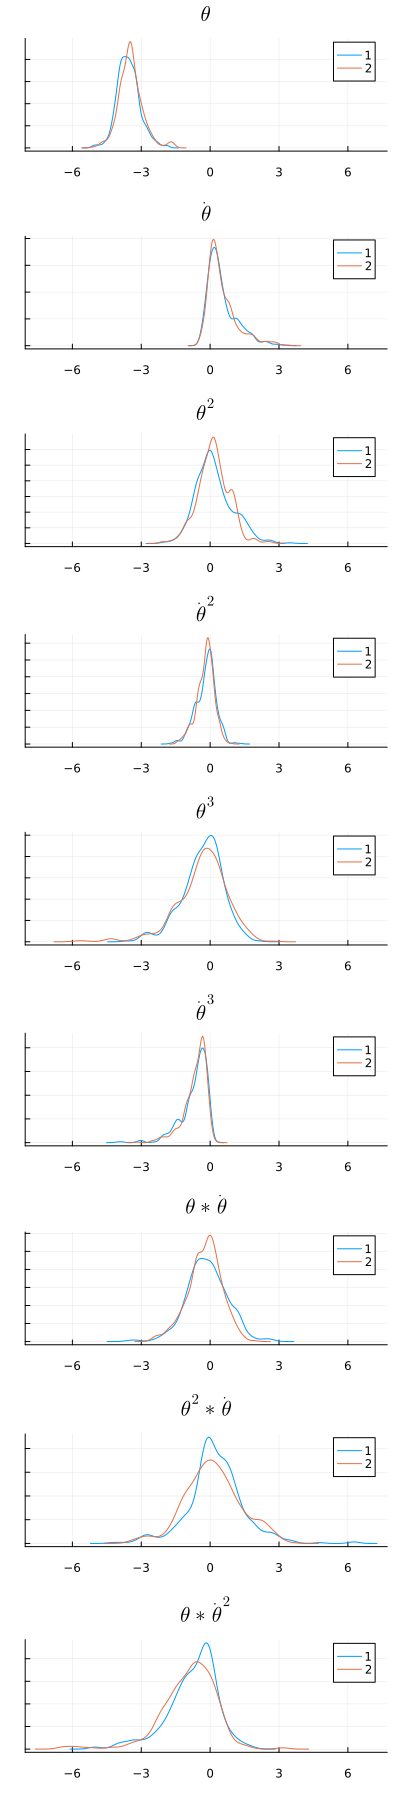

In [24]:
#| output: false
gdf = groupby(beta, :var)
plot_list = []
for ((k,), v) in pairs(gdf)
    push!(plot_list, @df v density(:value, group=(:chain), title=k))
end

plot(plot_list..., layout=(length(plot_list), 1), size=(400, 200 * length(plot_list)), link = :x)
    


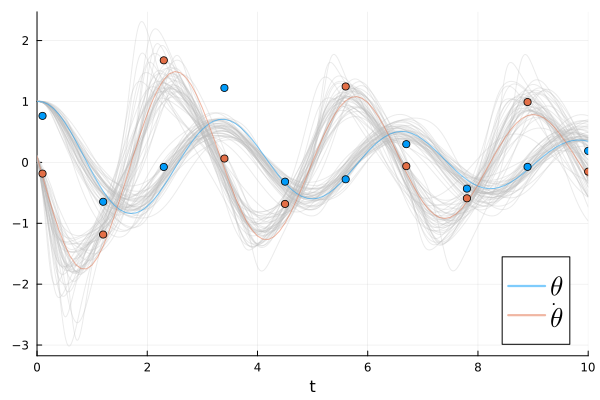

In [25]:
#| output: false
plot(;legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 1:25:size(finnish_df, 1)
    plot!(all_sol[i]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol; alpha=0.5, linewidth=1, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata'; color=[1 2], label="")


## Summary

The Laplacian priors allow better capturing of the DE than the horseshoe did